author: Raymond Yee ([@rdhyee](https://twitter.com/rdhyee)) <br/>
last edit: 2015.05.31

# Why Care about Quarry?

After expending considerable effort using the Wikipedia API to assemble a database of user edit metadata in support of the work reported "[Gender Differences in Wikipedia Editing](https://dl.acm.org/citation.cfm?doid=2038558.2038561)" (a [prize-winning short paper](http://www.wikisym.org/2011/09/21/best-paper-winners-for-wikisym-2011/comment-page-1/) for [WikiSym 2011](http://www.wikisym.org/ws2011/start.html)), I've been long intrigued by having direct access to the database behind Wikipedia.  With direct database access, there would no need to accumulate data by polling the API, a laborious and error-prone process used for the paper.   Just [sign up for an account](https://wikitech.wikimedia.org/wiki/Help:Getting_Started#Create_a_User_Account) on [Wikimedia Labs](https://wikitech.wikimedia.org/wiki/Help:FAQ#What_is_Wikimedia_Labs.3F), and [connect to the live database replicas](https://wikitech.wikimedia.org/wiki/Help:Tool_Labs/Database#Connecting_to_the_database_replicas).  It helps to understand the [Mediawiki database layout](https://www.mediawiki.org/wiki/Manual:Database_layout) and to study [example MySQL queries that can be run on the replicas](https://wikitech.wikimedia.org/wiki/Nova_Resource:Tools/Shared_Resources/MySQL_queries).  Undoubtedly, there is a learning curve; there's lot of documentation out there but I've found it a chore to make sense of it all.  (If you get confused, don't forget to ask for help on the [Labs-l Mailing List](https://lists.wikimedia.org/mailman/listinfo/labs-l) or the [wikimedia labs IRC channel](https://webchat.freenode.net/?channels=#wikimedia-labs).

In my self-education about the Wikipedia databases, I've been particularly happy to find [Quarry](http://quarry.wmflabs.org), a web application (currently in beta), that allows one to "[r]un SQL queries against Wikipedia & other databases from your browser".  You can run SQL queries and see the results in the browser, download results, and also easily share your queries and results with others. You can also see what queries other people have run, from which you can presumably learn much.  (Finally, you don't need a shell account on Wikimedia Labs to use the service.)

I've been enjoying Quarry a lot, but wanted to integrated its functionality with other software.  Specifically, I wanted to integrate work I'm doing on Quarry with the [IPython/Jupyter notebook](https://en.wikipedia.org/wiki/IPython). To begin with, it'd be convenient to be able to programmatically access the output from queries. It turns out that you can make use of an implicit Quarry API to read not only the output data of a query but associated metadata, including the query SQL itself, the author, title, and date of execution.  Some things I describe here:

* What queries have I made at Quarry?  
* Specifically, can one get at which ones are published and drafts?  
* Can one get data on specific runs?  
* What queries are starred?

As I began to write integration with Quarry and surface my own work on Quarry, I then start to explore the question of what other people are doing on Quarry.  Such questions as:

* What users are there?  Can I get the same info for those folks?
* What popular queries are there?
* Can we understand the flow of use -- are people learning from each other?

This notebook shows some preliminary work in that area.

## How to learn more about Quarry

BTW, don't miss the [main documentation page for Quarry](https://meta.wikimedia.org/wiki/Research:Quarry) and [three-part Wikiresearch webinar series](https://meta.wikimedia.org/wiki/Grants:Evaluation/Wikiresearch_webinars), which includes videos ( [1](https://www.youtube.com/watch?v=IjvZJ6joQD4#t=12), [2](https://www.youtube.com/watch?v=V5Te4_mQq8Y), [3](https://www.youtube.com/watch?v=CcNoDplKqTc)) with some coverage on using Quarry.)

# Python imports

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

In [3]:
import datetime
from itertools import (islice, chain)
import re
import time
from collections import (Counter, OrderedDict)

# writing for eventual Python 2/3 compatability 

try:
    from urllib.parse import urlencode
except ImportError:
    from urllib import urlencode
        
import requests

from lxml.html import fromstring, parse

import matplotlib.pyplot as plt
from pandas import (DataFrame, Series)

from IPython.display import (display, HTML, Markdown)

# Working with results from a specific query

As a [big fan of the music of J. S. Bach](https://web.archive.org/web/20030414021116/http://iu.berkeley.edu/rdhyee/cosmicbach), I'm also very interested in the history of the [English Wikipedia page for Johann Sebastian Bach](https://en.wikipedia.org/wiki/Johann_Sebastian_Bach). How did the article develop over the years?  When was it most actively edited?

For a simple question to answer using Quarry, I wanted to compute [the number of revisions by year for Johann_Sebastian_Bach in enwiki](http://quarry.wmflabs.org/query/3659).  

The easiest workflow with which to begin is to refine a query on Quarry and then [download the resultset](https://meta.wikimedia.org/wiki/Research:Quarry#Downloading_a_resultset).   That is, for a recent run, I could analyze the output by first downloading the JSON-formatted data from <http://quarry.wmflabs.org/run/24183/output/0/json?download=true>.  But if I were to run the query again, the URL for the output changes again because the run number changes.




## A Python function to download information about a Quarry query

For the purposes of analyzing the output from queries in Quarry, instead of manually downloading the output of a Quarry query (and the accompanying metadata), it is ultimately easier to programatically obtain that output.  

Through a combination of reverse engineering Quarry, greatly helped the [open availability of source code for Quarry](https://github.com/wikimedia/analytics-quarry-web), I wrote the following Python functions to obtain the output and to display that output in a Jupyter notebook.

In [4]:
def quarry_result(query_id, rev_id=None, result_format='json'):
    """
    returns a dict {'status', 'output', 'query_meta' 'latest_run', 'latest_rev'} for a query_id on quarry.wmflabs.org
    """
    
    BASE_URL = "http://quarry.wmflabs.org"
    
    # get the metadata for the query
    # https://github.com/wikimedia/analytics-quarry-web/blob/e2346c5ec47d63f9514b8aef9190211fa5ff0e45/quarry/web/app.py#L402
    url = BASE_URL + "/query/{0}/meta".format(query_id)
    
    try: 
        query_meta = requests.get(url).json()
        status = query_meta['latest_run']['status']
        latest_run_id = query_meta['latest_run']['id']
        latest_rev_id = query_meta['latest_rev']['id']

        # if status is 'complete' and return_output is True,
        # grab the results -- unless result_format is None
        # https://github.com/wikimedia/analytics-quarry-web/blob/e2346c5ec47d63f9514b8aef9190211fa5ff0e45/quarry/web/app.py#L350

        if (status == 'complete' and result_format is not None):
            # TO DO: figure out whether 0 should be a variable
            # re: https://github.com/wikimedia/analytics-quarry-web/blob/e2346c5ec47d63f9514b8aef9190211fa5ff0e45/quarry/web/app.py#L351
            # 0 is default value for resultset_id 
            url = BASE_URL + "/run/{0}/output/0/{1}".format(latest_run_id, result_format)
            if result_format == 'json':
                output = requests.get(url).json()
            else:
                output = requests.get(url).text
        else:
            output = None

        return {'query_meta':query_meta, 
                'status': status,
                'latest_run': latest_run_id,
                'latest_rev': latest_rev_id,
                'output': output
               }
    except Exception, e:
        return e
    
# assume for now latest rev id same as latest run id.
# 'status':query_meta["status"]
        
def display_objs_for_q_result(q):
    """
    returns IPython/Jupyter display object to describe query metadata and SQL content
    (first pass)
    """

    description = q['query_meta']['query']['description']
    if description is None:
        description = ""
        
    return ( HTML("<b>{0}</b>".format(q['query_meta']['query']['title'])),
             HTML("<p>id: {0} ({1})</p>".format(q['query_meta']['query']['id'], 
                                                        q['query_meta']['query']['timestamp'])),
             HTML("<p>{0}</p>".format(description)),
             Markdown("""```sql\n{0}\n```""".format(q['query_meta']['latest_rev']['sql']))
            )



Now to retrieve and display the metadata for the query `3659` <http://quarry.wmflabs.org/query/3659>

In [5]:
q = quarry_result(3659, result_format='json')
display(*display_objs_for_q_result(q))

```sql
SELECT 
   YEAR(rev_timestamp), COUNT(rev_timestamp) 
FROM revision 
WHERE rev_page = 9906294 # page_id for https://en.wikipedia.org/wiki/Johann_Sebastian_Bach
GROUP BY YEAR(rev_timestamp);
```

Show the output from the query

In [6]:
q['output']

{u'headers': [u'YEAR(rev_timestamp)', u'COUNT(rev_timestamp)'],
 u'meta': {u'query_id': 3659, u'rev_id': 24189, u'run_id': 24189},
 u'rows': [[2001, 2],
  [2002, 21],
  [2003, 58],
  [2004, 146],
  [2005, 941],
  [2006, 1138],
  [2007, 1331],
  [2008, 282],
  [2009, 277],
  [2010, 263],
  [2011, 224],
  [2012, 481],
  [2013, 102],
  [2014, 328],
  [2015, 81]]}

Put the output into a [pandas DataFrame](http://pandas.pydata.org/pandas-docs/dev/generated/pandas.DataFrame.html) 

In [7]:
df = DataFrame(q['output']['rows'], columns=['year', 'count'])
df.set_index(keys='year', inplace=True, drop=True)
df

,count
year,
2001,2
2002,21
2003,58
2004,146
2005,941
2006,1138
2007,1331
2008,282
2009,277


Make a bar chart of the revision counts for the Bach article by year

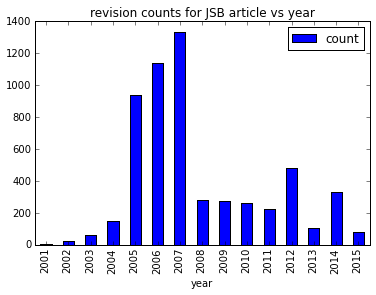

In [8]:
df.plot(kind='bar', title="revision counts for JSB article vs year")

This chart alone brings up many questions for future exploration.  Why is there a large amount of activity between 2005 to 2007, followed by a dramatic decrease in 2008?  Did activity in authorship about Bach-related articles decline only for [Johann Sebastian Bach - Wikipedia, the free encyclopedia](http://en.wikipedia.org/wiki/Johann_Sebastian_Bach) alone or was there movement in authorship to related articles?

# Getting all queries for a given username

The query I wrote about Bach was only one of the queries I wrote on Quarry.  Once I could programmatically retrieve a single query, I wanted to interact with all the queries that I had created. To that end, I wrote `user_queries` to retrieve all the queries for a given user by scraping the profile page for a given user.  For example, <http://quarry.wmflabs.org/RaymondYee> has all the queries for the user `RaymondYee`.

(I was hoping that the queries would be available to some type of JSON format, but I couldn't find such a source.  The [source code for Quarry](https://github.com/wikimedia/analytics-quarry-web/blob/e2346c5ec47d63f9514b8aef9190211fa5ff0e45/quarry/web/app.py#L154) confirms my suspicion that I need to scrape the profile page for a given user.)

In [9]:
# types of queries

from collections import OrderedDict

query_type_headers = OrderedDict([
        ('published', 'Published queries'),
        ('draft', 'Draft Queries'),
        ('starred', 'Starred Queries')
    ])


def user_queries(username):
    """
    get all queries for a user
    e.g., parse http://quarry.wmflabs.org/RaymondYee
    """
    
    url = u"http://quarry.wmflabs.org/{0}".format(username)
    r = requests.get(url)
    page = requests.get(url).content.decode("UTF-8")
    doc = fromstring(page)
    
    # xpath expressions correlate with template
    # https://github.com/wikimedia/analytics-quarry-web/blob/e2346c5ec47d63f9514b8aef9190211fa5ff0e45/quarry/web/templates/user.html
    
    # number of queries
    queries = dict()
    queries['num_queries'] =int(doc.xpath('//*[@class="user-stat"]/h2/text()')[0])
    

    # loop through all the query types
    for (qtype, qheader) in query_type_headers.items():
        q_elements = doc.xpath('//h3[contains(text(),"{0}")][1]/following-sibling::ul[1]/li/a'.format(qheader))
        q_results = []
        for q in q_elements:
            q_id = int(q.attrib['href'].split('/')[-1])
            #result = quarry_result(q_id, result_format=None)
            q_results.append( (q_id, q.text))
        queries[qtype] = q_results
        
    return queries
        

Let's now retrieve my queries

In [10]:
uq = user_queries('RaymondYee')
uq

{'draft': [(5292, '[empty]'),
  (5353, '[empty]'),
  (3659, 'number of revisions by year for Johann_Sebastian_Bach in enwiki'),
  (3784, 'None'),
  (3783, 'None'),
  (3781, 'categories containing Johann_Sebastian_Bach page in enwiki'),
  (3756, 'None'),
  (3755, 'None'),
  (3753, 'None'),
  (3664, 'All pages in enwiki with title of Johann_Sebastian_Bach'),
  (3736, 'None'),
  (3717, 'None'),
  (3714, 'Examples of data in wikidatawiki_p.wb_changes'),
  (3706, 'First messages to users, by tool/bot used (if any)'),
  (3693, 'None'),
  (3690, 'Last registered users'),
  (3689, 'None'),
  (3651, 'Revision timestamp and length for Johann_Sebastian_Bach in enwiki'),
  (3685, 'None'),
  (3650, 'None'),
  (3646, 'Number of edited pages in enwiki since 2015.05.17')],
 'num_queries': 40,
 'published': [(3713, 'count of members in user groups in Wikidata'),
  (3700, 'list of all databases'),
  (3702, ' Ten most recently created user accounts in enwiki_p'),
  (3647, 'Last ten revisions to the Johan

Putting a bit more work, we can make it easier to jump back to the original queries on Quarry.

In [11]:
queries_display = ""
queries_display += "<p>number of queries: {0}</p>".format(uq['num_queries'] )

for (qtype, qheader) in query_type_headers.items():
    queries_display += "<b>{0}</b><br/>".format(qheader)
    for (q_id, q_title) in uq[qtype]:
        queries_display += "<div>{0} <a href='http://quarry.wmflabs.org/query/{0}'>{1}</a></div>".format(q_id, q_title)
    queries_display += "<br/>"
    
HTML(queries_display)

We can print out all the SQL for the queries too.  Here's the description and SQL for my published and draft queries.

In [12]:
uq

{'draft': [(5292, '[empty]'),
  (5353, '[empty]'),
  (3659, 'number of revisions by year for Johann_Sebastian_Bach in enwiki'),
  (3784, 'None'),
  (3783, 'None'),
  (3781, 'categories containing Johann_Sebastian_Bach page in enwiki'),
  (3756, 'None'),
  (3755, 'None'),
  (3753, 'None'),
  (3664, 'All pages in enwiki with title of Johann_Sebastian_Bach'),
  (3736, 'None'),
  (3717, 'None'),
  (3714, 'Examples of data in wikidatawiki_p.wb_changes'),
  (3706, 'First messages to users, by tool/bot used (if any)'),
  (3693, 'None'),
  (3690, 'Last registered users'),
  (3689, 'None'),
  (3651, 'Revision timestamp and length for Johann_Sebastian_Bach in enwiki'),
  (3685, 'None'),
  (3650, 'None'),
  (3646, 'Number of edited pages in enwiki since 2015.05.17')],
 'num_queries': 40,
 'published': [(3713, 'count of members in user groups in Wikidata'),
  (3700, 'list of all databases'),
  (3702, ' Ten most recently created user accounts in enwiki_p'),
  (3647, 'Last ten revisions to the Johan

In [13]:
ry_results = [quarry_result(q_id, result_format=None) 
    for q_id in chain([q_id for (q_id, title) in uq['published']],
                      [q_id for (q_id, title) in uq['draft']])
              ]

# the following way to display the results is a bit opaque and should be rewritten
display(*list(chain(*[display_objs_for_q_result(r) for r in ry_results if not isinstance(r, Exception)])))

```sql
USE wikidatawiki_p;

SELECT 
	ug_group, COUNT(ug_group)
FROM
	user_groups
GROUP BY
	ug_group;
```

```sql
SHOW DATABASES;
```

```sql
USE enwiki_p;



SELECT 
	u.user_id, u.user_name, NOW(), u.user_registration, u.user_editcount
FROM
	user u
ORDER BY
	u.user_id DESC
LIMIT 10;
```

```sql
select * from revision where rev_page = 9906294 ORDER BY rev_timestamp DESC  LIMIT 10;
```

```sql
SELECT 
	cl_from, cl_to, cl_timestamp, cl_type, p1.page_title as from_title, p2.page_id as to_page_id
FROM
	categorylinks cl  JOIN page p1  JOIN page p2
ON
	cl.cl_from = p1.page_id AND cl.cl_to = p2.page_title
WHERE
	p2.page_title = "Johann_Sebastian_Bach" AND p2.page_namespace = 14;
```

```sql
USE enwiki_p;

SELECT 
	UNIX_TIMESTAMP() - UNIX_TIMESTAMP(rc_timestamp) 
AS
	replication_lag
FROM 
	recentchanges 
ORDER BY 
	rc_timestamp 
DESC LIMIT 1;
```

```sql
SELECT
   GROUP_CONCAT(lv SEPARATOR ',') 
FROM
  (
    SELECT
        @pv:= (
            SELECT
                GROUP_CONCAT(from_id SEPARATOR ',')
            FROM
                (
					SELECT 
						cl_from as from_id, p1.page_title as from_title,  p2.page_id as to_id, cl_to as to_title, cl_type
					FROM
						categorylinks cl JOIN page p1 JOIN page p2
					ON
						cl.cl_from = p1.page_id AND cl.cl_to = p2.page_title
				) AS Folder
            WHERE
                to_id IN (@pv)
            )
    AS 
        lv
    FROM
               (
					SELECT 
						cl_from as from_id, p1.page_title as from_title,  p2.page_id as to_id, cl_to as to_title, cl_type
					FROM
						categorylinks cl JOIN page p1 JOIN page p2
					ON
						cl.cl_from = p1.page_id AND cl.cl_to = p2.page_title
				) AS Folder2
    JOIN
        (SELECT @pv:=(SELECT page_id FROM page WHERE page_title = 'Johann_Sebastian_Bach' AND page_namespace = 14)) tmp
    WHERE
        to_id IN (@pv)
        
  ) a;

```

```sql
USE wikidatawiki_p;

SELECT 
	*
FROM
	wb_terms
WHERE
	term_entity_id = '671480'  # Albany,_California
```

```sql
SELECT 
	ug_group, COUNT(ug_group)
FROM
	user_groups
GROUP BY
	ug_group;
```

```sql
USE enwiki_p;

SELECT 
	*
FROM
	site_stats;
```

```sql
USE enwiki_p;

SELECT 
	DISTINCT(page_namespace)
FROM
	page;


```

```sql
SET @user_name = 'RaymondYee';



USE enwiki_p;

SELECT 
	u.user_id, u.user_name, u.user_registration, u.user_editcount, up.up_property, up.up_value
FROM
	user u
LEFT JOIN
    user_properties up
ON 
	u.user_id = up.up_user
WHERE
	u.user_name = @user_name
```

```sql
USE enwiki_p;

SELECT 
  DISTINCT(up_property)
FROM
	user_properties;
```

```sql

# parameters

SET @page_title = 'Johann_Sebastian_Bach';
SET @namespace = 0;   # main namespace


# query

USE enwiki_p;


SELECT
  r.rev_id, r.rev_timestamp, r.rev_len, p.page_title
FROM 
  revision r
LEFT JOIN page p ON
  r.rev_page =  p.page_id 
WHERE
  p.page_title = @page_title AND
  p.page_namespace = @namespace 
```

```sql
use enwiki_p;

SELECT rc_title, COUNT(*) AS num_edits
FROM recentchanges 
WHERE rc_namespace = 0 
GROUP BY 1 ORDER BY 2 DESC
LIMIT 25;
```

```sql
USE enwiki_p;

SHOW TABLE STATUS FROM 
   enwiki_p
LIKE 'revision';

```

```sql
SELECT 
  COUNT(*) 
FROM revision 
WHERE 
  rev_timestamp > 20150519000000
```

```sql
SELECT
  page_title,
  page_len
FROM categorylinks
RIGHT JOIN page ON cl_to = page_title
WHERE page_namespace = 14
AND page_is_redirect = 0
AND cl_to IS NULL
AND NOT EXISTS (SELECT
                  1
                FROM categorylinks
                WHERE cl_from = page_id
                AND cl_to = 'Wikipedia_category_redirects')
AND NOT EXISTS (SELECT
                  1
                FROM categorylinks
                WHERE cl_from = page_id
                AND cl_to = 'Disambiguation_categories')
AND NOT EXISTS (SELECT
                  1
                FROM templatelinks
                WHERE tl_from = page_id
                AND tl_namespace = 10
                AND tl_title = 'Empty_category');
```

```sql
SELECT 
	COUNT(page_title) 
FROM enwiki_p.page 
WHERE 
	(page_touched >= 20150517000000) 
      AND 
	(page_touched <  20150518000000);
```

```sql

```

```sql

```

```sql
SELECT 
   YEAR(rev_timestamp), COUNT(rev_timestamp) 
FROM revision 
WHERE rev_page = 9906294 # page_id for https://en.wikipedia.org/wiki/Johann_Sebastian_Bach
GROUP BY YEAR(rev_timestamp);
```

```sql
USE wikidatawiki_p;

SELECT
	*
FROM
	pagelinks
LIMIT 10;
```

```sql
SELECT * FROM

categorylinks cl

JOIN
(SELECT 
	page_id, page_title
FROM
	page
WHERE
	page_title = "Johann_Sebastian_Bach" and page_namespace=0) jsb
ON
	cl.cl_from = jsb.page_id;

```

```sql
SELECT
   GROUP_CONCAT(lv SEPARATOR ',') 
FROM
  (
    SELECT
        @pv:= (
            SELECT
                GROUP_CONCAT(child_id SEPARATOR ',')
            FROM
                (
					SELECT 
						cl_from as child_id, p2.page_id as parent_id, cl_type
					FROM
						categorylinks cl JOIN page p1 JOIN page p2
					ON
						cl.cl_from = p1.page_id AND cl.cl_to = p2.page_title
				) AS Folder
            WHERE
                parent_id IN (@pv)
            )
    AS 
        lv
    FROM
               (
					SELECT 
						cl_from as child_id, p2.page_id as parent_id, cl_type
					FROM
						categorylinks cl JOIN page p1 JOIN page p2
					ON
						cl.cl_from = p1.page_id AND cl.cl_to = p2.page_title
				) AS Folder2
    JOIN
        (SELECT @pv:=30529496) tmp #Johann_Sebastian_Bach
    WHERE
        parent_id IN (@pv)
        
  ) a;
```

```sql
SELECT COUNT(page_id) FROM page WHERE page_namespace = 14;
```

```sql
USE enwiki_p;


SELECT 
  *
FROM 
  page 
WHERE
  page_title = "Johann_Sebastian_Bach";
```

```sql
use enwiki_p;

SELECT 
	cl_from, cl_to, cl_timestamp, cl_type, p1.page_title as from_title, p2.page_id as to_page_id
FROM 
	categorylinks cl
LEFT JOIN
	page p1
ON
	cl.cl_from = p1.page_id
LEFT JOIN
	page p2
ON
	cl.cl_to = p2.page_title
WHERE
	cl.cl_to = "Johann_Sebastian_Bach"
```

```sql
SELECT user_id, user_name, user_registration, user_editcount
	FROM enwiki_p.user
	WHERE user_registration > DATE_FORMAT(DATE_SUB(NOW(),INTERVAL 1 DAY),'%Y%m%d%H%i%s')
	AND user_editcount > 10
	AND user_id NOT IN (SELECT ug_user FROM enwiki_p.user_groups WHERE ug_group = 'bot')
	AND user_name not in (SELECT REPLACE(log_title,"_"," ") from enwiki_p.logging
		where log_type = "block" and log_action = "block"
		and log_timestamp >  DATE_FORMAT(DATE_SUB(NOW(),INTERVAL 2 DAY),'%Y%m%d%H%i%s'));
```

```sql
USE wikidatawiki_p;

SELECT 
	*
FROM
	wb_changes
LIMIT 10
```

```sql

SET @user_name = 'RaymondYee';

USE enwiki_p;

SELECT
 page_id, page_title, rev_comment,rev_user, rev_user_text,
 CAST(rev_timestamp AS datetime) AS rev_timestamp, CAST(user_registration AS datetime) AS user_registration,
 datediff(rev_timestamp,user_registration) AS datediff_msg_reg, timediff(rev_timestamp,user_registration) AS timediff_msg_reg,
 DATE_FORMAT(user_registration,"%Y-%m-%d") AS user_reg_ymd, DATE_FORMAT(rev_timestamp,"%Y-%m-%d") AS first_msg_ymd, user_id,
 (rev_comment LIKE '%WP:HG%' OR rev_comment LIKE '%WP:HUGGLE%') AS huggle, (rev_comment LIKE '%WP:TW%') tw,
 (rev_comment LIKE '%igloo|GLOO]]%') AS gloo,
 (rev_comment LIKE '%WP:STiki%') AS stiki,
 (rev_user_text LIKE 'ClueBot%') AS cluebot,
 (rev_user_text = 'XLinkBot') AS xlinkbot,
 (rev_user_text = 'CorenSearchBot') AS corenbot,
 (rev_user_text LIKE 'BetacommandBot%') AS betacommandbot,
 (rev_user_text LIKE '%Bot') AS bot,
 (rev_user_text LIKE page_title) AS SELF
FROM page 
LEFT JOIN revision ON page_id = rev_page
LEFT JOIN user ON REPLACE(page_title,"_"," ") = @user_name
WHERE page_namespace = 3 AND LOCATE('/',page_title) = 0 
GROUP BY page_id;
```

```sql
USE enwiki_p;

DESCRIBE user_properties;
```

```sql
USE enwiki_p;

SELECT 
	u.user_id, u.user_name, u.user_registration, u.user_editcount
FROM
	user u
ORDER BY
	u.user_id DESC
LIMIT 10;
```

```sql
select rev_id, rev_timestamp, rev_len from revision where rev_page = 9906294 ORDER BY rev_timestamp ASC;
```

```sql
select count(page_title) from enwiki_p.page where page_touched > 20150517000000;
```

In [14]:
# problematic queries
# https://quarry.wmflabs.org/query/{q_id/}meta

from itertools import izip

q_ids = list(chain([q_id for (q_id, title) in uq['published']],
                      [q_id for (q_id, title) in uq['draft']]))

[(id_) for (id_,r) in izip(q_ids, ry_results) if isinstance(r, Exception)]

[3783, 3755, 3689, 3685, 3650]

One of the next steps I'd want to pursue is to figure out how to programmatically write to Quarry, for example, formulate queries in Python and then send them to Qurray.  As a Wikimedia Lab user, I'd want to be able to move queries between Quarry and the job submission facility on the Labs.

# Analyzing queries of all Quarry users collectively


A major part of the appeal of Quarry is that you are part of a community of users creating queries.  I personally wanted to understand what others are doing on Quarry. 

To satisfy my curiosity, I decided to scrape the [Recent Queries](http://quarry.wmflabs.org/query/runs/all) page for a list of queries and their creators by writing `runs_list`.  The function `runs_list` will loop all the queries by paging through the entire history available on [Recent Queries](http://quarry.wmflabs.org/query/runs/all).


In [15]:
def anchor_info_or_text(td):
    anchors = td.xpath('a')
    if anchors:
        #if anchor text in form of "/query/query_id", return just query_id
        href = anchors[0].attrib['href']
        query_search = re.search("/query/(\d+)", href)
        if query_search:
            return (int(query_search.group(1)), anchors[0].text )
        else:
            return (href, anchors[0].text )
    else:
        return td.text
    
def filter_none(d):
    """
    return dict d without any items with None for value
    """
    return dict([(k,v) for (k,v) in d.items() if v is not None])

def runs_list(limit=None, from_=None, _sleep=0):
    """
    Generator for all the queries on http://quarry.wmflabs.org/query/runs/all
    """
    
    url = ("http://quarry.wmflabs.org/query/runs/all?" +
            urlencode(filter_none({'from':from_, 'limit':limit})))    
    more_pages = True

    while more_pages:

        r = requests.get(url)
        page = requests.get(url).content.decode("UTF-8")
        doc = fromstring(page)

        # grab headers
        headers = [th.text for th in doc.xpath("//th")]
        
        # yield rows
        for tr in doc.xpath("//tr[td]"):
            yield [anchor_info_or_text(td) for td in tr]
        
        # next link
        next_links = doc.xpath('//li[@class="next"]/a')
        if next_links:
            url = ("http://quarry.wmflabs.org/query/runs/all?" +
                 next_links[0].attrib['href'])
        else:
            more_pages = False
            
        time.sleep(_sleep)


Let's scrape the pages.  As of 2015-05-30, there are few enough queries for me to practically get all the pages returned by Quarry.

In [16]:
print ("time of analysis:", datetime.datetime.utcnow().isoformat(), "\n")
queries = []

# loop and print out which row we're on

for (i, item) in enumerate(islice(runs_list(_sleep=0.5), None)):
    print("\r {0}".format(i), end="")
    queries.append( (item[0][0], item[0][1], item[1][1], item[2], item[3]))

time of analysis: 2015-09-26T13:19:12.281507 

 3549

Display the last five results

In [17]:
df = DataFrame(queries, columns=['id', 'title', 'creator','status', 'time'])
df.tail()

,id,title,creator,status,time
3545,5295,Edits and Editors on Learning Pattern portal,Abittaker (WMF),complete,4 days ago
3546,5294,pages per namespace at mediawikiwiki,Quiddity (WMF),complete,4 days ago
3547,5291,Untitled query #5291,Superzerocool,complete,4 days ago
3548,4628,Draft 2,Huji,complete,4 days ago
3549,5290,Users tabular,Huji,complete,4 days ago


How many queries records belong to me?

In [18]:
len(df[df.creator=='RaymondYee'])

152

How many unique query identifiers and creators are there in the data set?

In [19]:
# how many unique ids

len(df.id.unique()), len(df.creator.unique())

(200, 67)

I am surprised such a small number of unique queries.  It's possible my code has a bug that causes me to miss many queries.  Alternative, Quarry might only return a limited selection.  (*To figure out.*)

In [20]:
# loop through users to accumlate data on all user queries
# on the way to computing most starred query

queries_by_user = dict()

for (i, username) in enumerate(islice(df.creator.unique(),None)):
    print ("\r {0}".format(i), end="")
    queries_by_user[username] = user_queries(username)

 66

Now let's compute the queries that have been starred by others and the number of stars they have received.

In [21]:
# let's look at what starred

starred_q = Counter()

for (u, d) in queries_by_user.items():
    for q in d['starred']:
        starred_q.update([q])    

starred_q_display = ""

for (q, count) in starred_q.most_common():
    starred_q_display += "<div><a href='http://quarry.wmflabs.org/query/{0}'>{1}</a>: {2}</div>".format(q[0],q[1],count)

HTML(starred_q_display)

# Some Next Steps

There are lot of other aspects of Quarry to explore, not to mention the Wikimedia databases themselves!  Some ideas are:

* compare SQL code among all the queries.  What queries are similar to each other?
* write Python functions to write jobs directly to Quarry.
* move jobs between Quarry and the job submission system on the Wikimedia Labs